In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as pylab
import numpy as np
import pandas as pd
import random
%matplotlib inline

In [3]:
import re

In [4]:
sentences = """Throughout my career, I have had the opportunity to work on this type of network  a diverse range of mobile app projects. My proficiency in Flutter, along with my Android development skills, has allowed me to create user-friendly and high-performance applications. I take pride in my ability to transform creative concepts into functional, feature-rich apps that deliver exceptional user experiences."""
sentences
# with open('input.txt', 'r') as file:
#     content = file.read()

# # Print the content
# print(content)

'Throughout my career, I have had the opportunity to work on this type of network  a diverse range of mobile app projects. My proficiency in Flutter, along with my Android development skills, has allowed me to create user-friendly and high-performance applications. I take pride in my ability to transform creative concepts into functional, feature-rich apps that deliver exceptional user experiences.'

In [15]:
# sentences=content
# sentences

Clean Data

In [5]:
# remove special characters
sentences = re.sub('[^A-Za-z0-9]+', ' ', sentences)

# remove 1 letter words
sentences = re.sub(r'(?:^| )\w(?:$| )', ' ', sentences).strip()

# lower all characters
sentences = sentences.lower()

Vocabulary

In [6]:
words = sentences.split()
vocab = set(words)
vocab

{'ability',
 'allowed',
 'along',
 'and',
 'android',
 'app',
 'applications',
 'apps',
 'career',
 'concepts',
 'create',
 'creative',
 'deliver',
 'development',
 'diverse',
 'exceptional',
 'experiences',
 'feature',
 'flutter',
 'friendly',
 'functional',
 'had',
 'has',
 'have',
 'high',
 'in',
 'into',
 'me',
 'mobile',
 'my',
 'network',
 'of',
 'on',
 'opportunity',
 'performance',
 'pride',
 'proficiency',
 'projects',
 'range',
 'rich',
 'skills',
 'take',
 'that',
 'the',
 'this',
 'throughout',
 'to',
 'transform',
 'type',
 'user',
 'with',
 'work'}

In [7]:
vocab_size = len(vocab)
embed_dim = 10              # each word will be represented by a 10-dimensional vector (specifies how detailed each word’s representation will be)
context_size = 2

Implementation

In [ ]:
word_to_ix = {word: i for i, word in enumerate(vocab)}              # Maps words to unique indices
ix_to_word = {i: word for i, word in enumerate(vocab)}              # Maps indices back to words

Data bags

In [ ]:
# Create context-target pairs from the word list
# data - [(context), target]

data = []
for i in range(2, len(words) - 2):
    context = [words[i - 2], words[i - 1], words[i + 1], words[i + 2]]
    target = words[i]
    data.append((context, target))
print(data[:5])

[(['throughout', 'my', 'have', 'had'], 'career'), (['my', 'career', 'had', 'the'], 'have'), (['career', 'have', 'the', 'opportunity'], 'had'), (['have', 'had', 'opportunity', 'to'], 'the'), (['had', 'the', 'to', 'work'], 'opportunity')]


Embeddings

In [ ]:
# Initialize random embeddings for each word in the vocabulary
embeddings =  np.random.random_sample((vocab_size, embed_dim))

Linear Model

In [ ]:
# Linear transformation function for input matrix with weights
def linear(m, theta):
    w = theta                       # Weight matrix
    return m.dot(w)

Log softmax + NLLloss = Cross Entropy

In [ ]:
# compute log probabilities (log of softmax) for stability in probability distribution
def log_softmax(x):
    e_x = np.exp(x - np.max(x))
    return np.log(e_x / e_x.sum())                  # Return average negative log likelihood

In [13]:
# negative log likelihood loss
def NLLLoss(logs, targets):
    out = logs[range(len(targets)), targets]
    return -out.sum()/len(out)

In [14]:
def log_softmax_crossentropy_with_logits(logits,target):

    out = np.zeros_like(logits)
    out[np.arange(len(logits)),target] = 1

    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)

    return (- out + softmax) / logits.shape[0]

Forward function

In [ ]:
# Forward function to calculate embedding and probabilities for a context
def forward(context_idxs, theta):
    m = embeddings[context_idxs].reshape(1, -1)                 # Embed context words and flatten
    n = linear(m, theta)                                        # Apply linear transformation
    o = log_softmax(n)                                          # Apply log-softmax for probabilities

    return m, n, o

Backward function

In [ ]:
# Backward function to compute gradient for optimization
def backward(preds, theta, target_idxs):
    m, n, o = preds

    dlog = log_softmax_crossentropy_with_logits(n, target_idxs)             # Gradient for weights
    dw = m.T.dot(dlog)

    return dw

Optimize function

In [ ]:
# weights are updated
def optimize(theta, grad, lr=0.03):
    theta -= grad * lr
    return theta

Training

In [ ]:
# Initialize theta with random values for model weights
theta = np.random.uniform(-1, 1, (2 * context_size * embed_dim, vocab_size))

TRAIN MODEL

In [ ]:
# Train the model and collect losses per epoch
epoch_losses = {}

for epoch in range(80):

    losses =  []

    for context, target in data:
        context_idxs = np.array([word_to_ix[w] for w in context])               # Convert context words to indices
        preds = forward(context_idxs, theta)

        target_idxs = np.array([word_to_ix[target]])                            # Convert target word to index
        loss = NLLLoss(preds[-1], target_idxs)                                  # Compute loss for the prediction

        losses.append(loss)

        grad = backward(preds, theta, target_idxs)                              # Compute gradient
        theta = optimize(theta, grad, lr=0.03)                                  # Update model weights with gradient descent


    epoch_losses[epoch] = losses

Analyze

Plot loss/epoch

Text(0, 0.5, 'Losses')

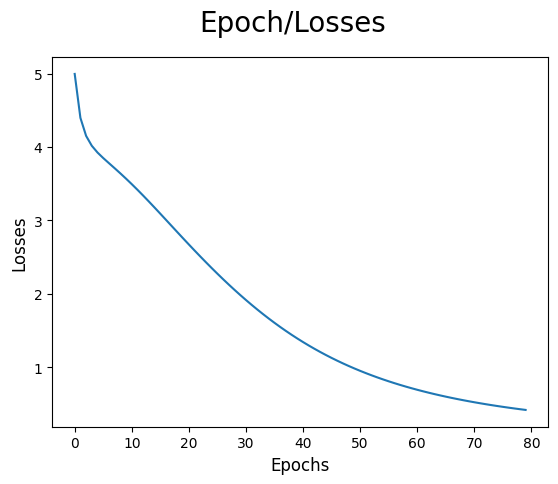

In [ ]:
ix = np.arange(0,80)

fig = plt.figure()
fig.suptitle('Epoch/Losses', fontsize=20)
plt.plot(ix,[epoch_losses[i][0] for i in ix])                       # Plot first loss of each epoch
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Losses', fontsize=12)

Predict function

In [21]:
def predict_from_context(data):
    # Randomly select a context-target pair for prediction
    random_pair = random.choice(data)
    context, target = random_pair
    print(f"\nPrediction based on context: {context}")
    return target

In [28]:

predict_from_context(data)


Prediction based on context: ['proficiency', 'in', 'along', 'with']


'flutter'

Accuracy

In [ ]:
def accuracy():
    wrong = 0

    for context, target in data:
        if(predict_from_context(data)==target):
            wrong += 1
    return (1 - (wrong / len(data)))

In [27]:
accuracy()


Prediction based on context: ['my', 'android', 'skills', 'has']

Prediction based on context: ['to', 'transform', 'concepts', 'into']

Prediction based on context: ['into', 'functional', 'rich', 'apps']

Prediction based on context: ['development', 'skills', 'allowed', 'me']

Prediction based on context: ['this', 'type', 'network', 'diverse']

Prediction based on context: ['along', 'with', 'android', 'development']

Prediction based on context: ['into', 'functional', 'rich', 'apps']

Prediction based on context: ['opportunity', 'to', 'on', 'this']

Prediction based on context: ['my', 'android', 'skills', 'has']

Prediction based on context: ['functional', 'feature', 'apps', 'that']

Prediction based on context: ['pride', 'in', 'ability', 'to']

Prediction based on context: ['pride', 'in', 'ability', 'to']

Prediction based on context: ['me', 'to', 'user', 'friendly']

Prediction based on context: ['have', 'had', 'opportunity', 'to']

Prediction based on context: ['my', 'career', 'had'

0.0357142857142857

In [ ]:
# def accuracy():
#     correct = 0  # Count correct predictions

#     for context, target in data:
#         predicted_target = predict_from_context(data)  # Get prediction
#         if predicted_target == target:
#             correct += 1  # Increment correct count if prediction matches

#     return correct / len(data)  # Return the accuracy as a fraction of correct predictions


# # Calculate and print the accuracy
# print(f"Accuracy: {accuracy() * 100:.2f}%")



Prediction based on context: ['android', 'development', 'has', 'allowed']

Prediction based on context: ['transform', 'creative', 'into', 'functional']

Prediction based on context: ['transform', 'creative', 'into', 'functional']

Prediction based on context: ['to', 'work', 'this', 'type']

Prediction based on context: ['the', 'opportunity', 'work', 'on']

Prediction based on context: ['create', 'user', 'and', 'high']

Prediction based on context: ['type', 'of', 'diverse', 'range']

Prediction based on context: ['my', 'android', 'skills', 'has']

Prediction based on context: ['development', 'skills', 'allowed', 'me']

Prediction based on context: ['that', 'deliver', 'user', 'experiences']

Prediction based on context: ['to', 'transform', 'concepts', 'into']

Prediction based on context: ['pride', 'in', 'ability', 'to']

Prediction based on context: ['type', 'of', 'diverse', 'range']

Prediction based on context: ['apps', 'that', 'exceptional', 'user']

Prediction based on context: ['a